<a href="https://colab.research.google.com/github/ryangithubaccount/DSA2000/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Mount Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Imports

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
#@title Model Run Setup

DEBUG=False

def f1_score ( threshold, y_pred, y_true ):
    bc_pred = (y_pred > threshold).astype(int)
    tp = np.sum(np.logical_and(bc_pred == 1, y_true == 1))
    fp = np.sum(bc_pred == 1) - tp
    fn = np.sum(np.logical_and(bc_pred == 0, y_true == 1))

    precision = 0
    if tp != 0:
      precision = tp / (tp + fp)
    recall = 0
    if tp != 0:
      recall = tp / (tp + fn)
    f1 = 0
    if precision != 0 and recall != 0:
      f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

def inference(model, data_loader, device):
    flag = False
    y_true = None
    y_pred = None
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            if flag:
              y_true = np.concatenate((y_true, labels.cpu()))
              y_pred = np.concatenate((y_pred, outputs.cpu()))
            else:
              y_true = np.array(labels.cpu())
              y_pred = np.array(outputs.cpu())
              flag = True
    return y_pred, y_true

def evaluate ( threshold, model, data_loader, device ):
    '''
    Calculate the classification error in (%)
    '''
    y_pred, y_true = inference(model, data_loader, device)
    return f1_score(threshold, y_pred, y_true)

def run(model, epochs, train_loader, criterion, optimizer, RESULTS_PATH, validation_loader=None, scheduler=None, MODEL_PATH=None, VAL_PATH=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f' Using {device}')
    model.to(device)
    col_names = ['epoch', 'train_loss']
    results_df = pd.DataFrame(columns=col_names).set_index('epoch')

    best_validation_f1 = 0
    for epoch in range(int(epochs)):
        model.train()

        total_loss = []

        for i, data in enumerate(train_loader, 0):
            x, y = data
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            prediction = model(x).to(device)

            loss = criterion(prediction, x)
            # loss.requires_grad= True
            loss.backward()
            optimizer.step()

            total_loss.append ( loss.item() )
            if i % 50 == 49:
                if DEBUG:
                    print(f'{epoch +1} \t{i+1} \t{np.mean(total_loss)}' )

        if scheduler != None:
            scheduler.step()
        train_loss = np.mean(total_loss)

        results_df.loc[epoch] = [train_loss]
        results_df.to_csv ( RESULTS_PATH )
        print(f'epoch: {epoch+1} train_loss: {train_loss}')

    torch.save(model, MODEL_PATH)
    print('Finished Training')


In [ ]:
#@title Hyperparameters

class Hyperparams():
    def __init__(self, train_loader):
        self.iterations = len(train_loader)
        self.epochs =  64000
        self.lr = 0.1
        self.momentum = 0.9
        self.weight_decay = 0.0001
        self.milestones = [32000,
                           48000]
        self.lr_multiplier = 0.1

In [ ]:
#@title ConvLayer Definition

class ConvLayer(nn.Module):
  def __init__(self, stride):
    super().__init__()
    self.kernel_size = 3
    self.padding = 1

    self.conv1 = nn.Conv2d(1, 1, padding=self.padding,
                               kernel_size=self.kernel_size, stride=stride, bias=False)
    self.relu = nn.ReLU()
    self.batchnorm = nn.BatchNorm2d(1)
    self.conv2 = nn.Conv2d(1, 1, padding=self.padding,
                               kernel_size=self.kernel_size, stride=1, bias=False)

    for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

  def skip_connection(self, F, X):
    '''
    F (tensor): block input
    x (tensor): activations of the block before relu

    If dimensions of input x are greater than activations then downsample and
    zero padding dimension 1 as described by option A in paper.
    '''
    X = X.to(torch.float32)
    F = F.to(torch.float32)
    if X.shape == F.shape:
      return torch.add(F, X)
    else:
      avgpool = nn.AvgPool2d(1, stride=2)
      X = avgpool(X)
      return torch.add(F, X)

  def forward(self, X):
    out = self.relu((self.conv1(X)))
    out = (self.conv2(out))
    out = self.skip_connection(out, X)
    out = self.relu(out)
    return out

In [ ]:
#@title Encoder Definition

class EncoderBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.stack = nn.ModuleList([ConvLayer(2)] + [ConvLayer(1) for _ in range(8)])

    def forward(self, X):
        out = X
        for layer in self.stack:
          out = layer(out)
        return out


class Encoder(nn.Module):
    def __init__(self, N, latent_dim, x_dim, y_dim):
        super().__init__()

        self.stack = nn.ModuleList([EncoderBlock() for _ in range(N)])

        self.flatten = nn.Flatten()

        self.linear = nn.Linear(x_dim * y_dim // (2 ** (2 * N)), latent_dim)

        # init weights in the fully connected layer
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()

    def forward(self, X):
        out = X
        for layer in self.stack:
            out = layer.forward(out)
        out = self.linear(self.flatten(out))

        return out

In [ ]:
#@title DeconvLayer Definition

class DeConvLayer(nn.Module):
  def __init__(self, stride):
    super().__init__()
    self.kernel_size = 3
    self.padding = 1

    self.conv1 = nn.ConvTranspose2d(1, 1, padding=self.padding, output_padding=int(stride > 1),
                               kernel_size=self.kernel_size, stride=stride, bias=False)
    self.relu = nn.ReLU()
    self.batchnorm = nn.BatchNorm2d(1)
    self.conv2 = nn.Conv2d(1, 1, padding=self.padding,
                               kernel_size=self.kernel_size, stride=1, bias=False)

    for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

  def skip_connection(self, F, X):
    '''
    F (tensor): block input
    x (tensor): activations of the block before relu

    If dimensions of input x are greater than activations then downsample and
    zero padding dimension 1 as described by option A in paper.
    '''
    X = X.to(torch.float32)
    F = F.to(torch.float32)
    if X.shape == F.shape:
      return torch.add(F, X)
    else:
      upsample = nn.Upsample(scale_factor=2)
      X = upsample(X)
      return torch.add(F, X)

  def forward(self, X):
    F = self.relu((self.conv1(X)))
    F = (self.conv2(F))
    F = self.skip_connection(F, X)
    F = self.relu(F)
    return F

In [ ]:
#@title Decoder Definition

class DecoderBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.stack = nn.ModuleList([DeConvLayer(2)] + [DeConvLayer(1) for _ in range(8)])

    def forward(self, X):
        out = X
        for layer in self.stack:
          out = layer(out)
        return out


class Decoder(nn.Module):
    def __init__(self, N, latent_dim, x_dim, y_dim):
        super().__init__()

        self.x_dim = x_dim
        self.y_dim = y_dim
        self.N = N

        self.stack = nn.ModuleList([DecoderBlock() for _ in range(N)])

        self.linear = nn.Linear(latent_dim, x_dim * y_dim // (2 ** (2 * N)))

    def forward(self, X):
        out = self.linear(X)
        out = out.reshape(out.shape[0], 1, self.x_dim // (2 ** self.N), self.y_dim // (2 ** self.N))
        for layer in self.stack:
            out = layer.forward(out)

        return out

In [ ]:
#@title AutoEncoder Definition

class AutoEncoder(nn.Module):
    def __init__(self, N, latent_dim, x_dim=128, y_dim=128):
        super().__init__()
        self.encoder = Encoder(N, latent_dim, x_dim, y_dim)
        self.decoder = Decoder(N, latent_dim, x_dim, y_dim)

    def forward(self, X):
        with torch.profiler.profile(
            profile_memory=False,
            record_shapes=False,
        ) as prof:
            out = self.decoder(self.encoder(X))

            prof.step()

        return out

In [ ]:
#@title Loader Definition

def load_data(train_dataset,
                      batch_size):

    labels = train_dataset
    tensor_x = torch.Tensor(train_dataset) # transform to torch tensor
    tensor_y = torch.Tensor(labels)

    train_dataset = TensorDataset(tensor_x,tensor_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    return train_dataset, train_loader

In [ ]:
#@title Initialize Data
batch_size = 64

# data = np.load('/content/drive/MyDrive/CS 101 Group/data/high_res/data.npy')
data = np.load('/content/drive/MyDrive/CS 101 Group/real_rfi_data_32x128.npy')

size = np.shape(data)[0]
print(f"size: {size}")

train_dataset = data[:int(size * 0.7)]
validation_dataset = data[int(size * 0.7): int(size * 0.85)]
test_dataset = data[int(size * 0.85):int(size * 0.85)+100]
# train_dataset = data[:1000]
# validation_dataset = data[1000:1200]
# test_dataset = data[1200:1400]

train_dataset = (train_dataset - np.mean(train_dataset)) / np.std(train_dataset)
validation_dataset = (validation_dataset - np.mean(validation_dataset)) / np.std(validation_dataset)
test_dataset = (test_dataset - np.mean(test_dataset)) / np.std(test_dataset)

_, train_loader = load_data(train_dataset, batch_size)
_, validation_loader = load_data(validation_dataset, np.shape(validation_dataset)[0])
_, test_loader = load_data(test_dataset, np.shape(test_dataset)[0])

size: 10238


In [ ]:
#@title Load Model

model = torch.load('/content/drive/MyDrive/CS 101 Group/Autoencoder/24by100')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda:0


In [ ]:
#@title Train New Model

autoEncoder = AutoEncoder(3, 64, 32, 128)

criterion = nn.MSELoss()
# criterion = nn.BCELoss()

params = Hyperparams ( train_loader )
params.lr=0.001
params.epochs=60
params.milestones[0]=int(params.epochs*1/2)
params.milestones[1]=int(np.ceil(params.epochs*3/4))
params.weight_decay = 5e-4

optimizer = torch.optim.Adam(params=autoEncoder.parameters(), lr=params.lr)

results_file = '/content/drive/MyDrive/CS 101 Group/Autoencoder/24by100.csv'
model_file = '/content/drive/MyDrive/CS 101 Group/Autoencoder/24by100'
val_file = '/content/drive/MyDrive/CS 101 Group/Autoencoder/24by100'

run(autoEncoder, params.epochs, train_loader, criterion,
          optimizer, results_file, MODEL_PATH=model_file, VAL_PATH=val_file, validation_loader=validation_loader)

 Using cuda:0
epoch: 1 train_loss: 228.75805317291193
epoch: 2 train_loss: 3.9574927730219707
epoch: 3 train_loss: 2.5812792916383063
epoch: 4 train_loss: 1.9670965277722903
epoch: 5 train_loss: 1.642752741064344
epoch: 6 train_loss: 1.4506814309528895
epoch: 7 train_loss: 1.329593474311488
epoch: 8 train_loss: 1.2488035240343638
epoch: 9 train_loss: 1.1922777774078506
epoch: 10 train_loss: 1.1517853438854218
epoch: 11 train_loss: 1.121602470853499
epoch: 12 train_loss: 1.098650334669011
epoch: 13 train_loss: 1.0810698068567686
epoch: 14 train_loss: 1.0671794387911047
epoch: 15 train_loss: 1.0560758811022555
epoch: 16 train_loss: 1.0471237104918276
epoch: 17 train_loss: 1.039899054914713
epoch: 18 train_loss: 1.0339743026665278
epoch: 19 train_loss: 1.029035450624568
epoch: 20 train_loss: 1.024946284613439
epoch: 21 train_loss: 1.0215362815984659
epoch: 22 train_loss: 1.0186755045184068
epoch: 23 train_loss: 1.016237912433488
epoch: 24 train_loss: 1.0141780823469162
epoch: 25 train_los

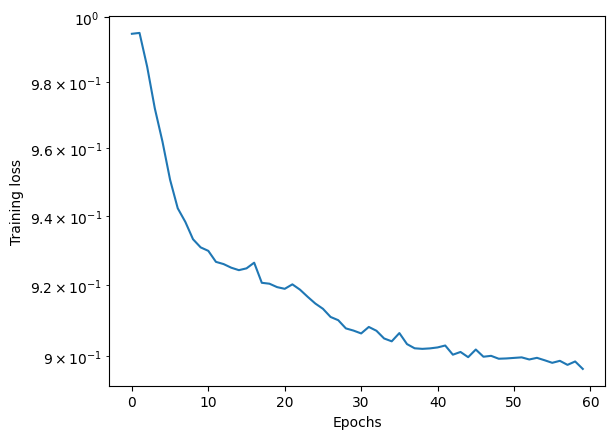

In [ ]:
#@title Plotting Loss Curves

def plot_curves(losses):
  plt.figure()
  plt.plot(losses['epoch'], losses['train_loss'])
  plt.xlabel("Epochs")
  plt.ylabel("Training loss")
  plt.yscale("log")
  plt.show()

losses = pd.read_csv('/content/drive/MyDrive/CS 101 Group/Autoencoder/1.csv')
plot_curves(losses)

In [ ]:
#@title Inference

y_pred, y_true = inference(model, test_loader, device)

0


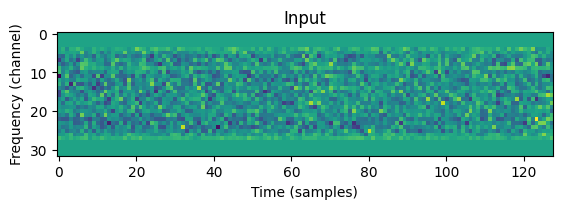

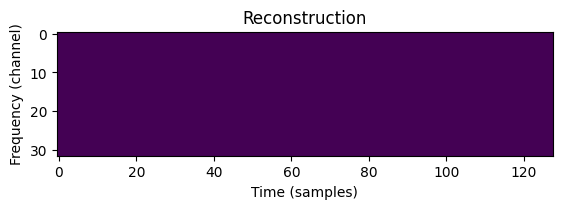

63


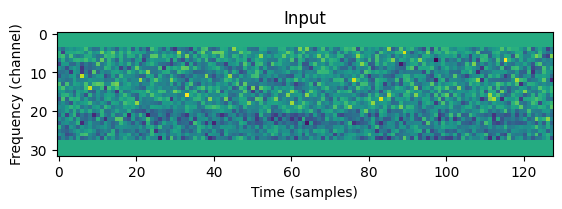

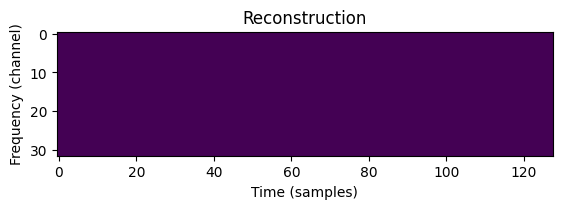

68


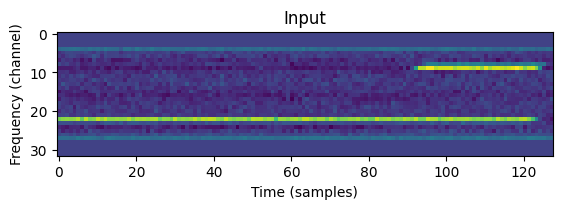

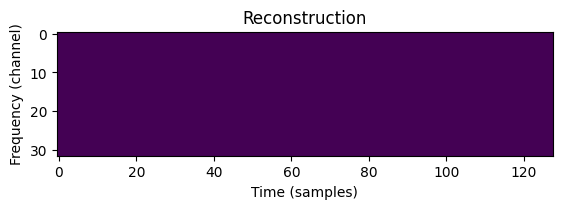

76


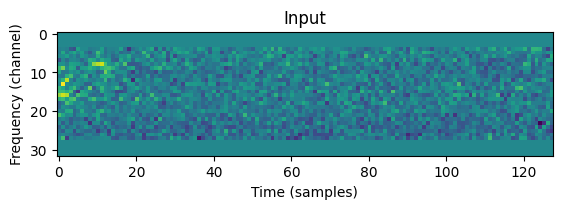

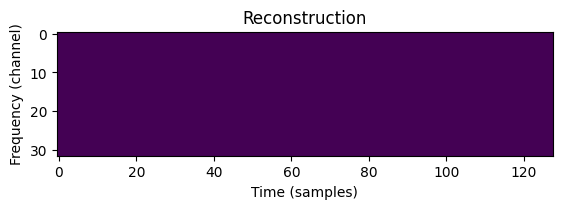

77


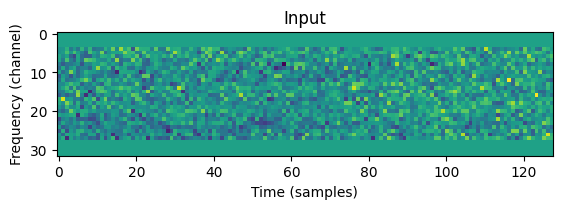

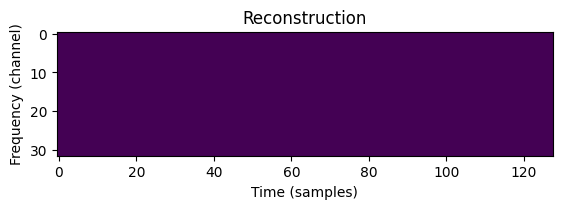

In [ ]:
#@title Reconstruction

for i in range(len(y_true)):
  if abs(sum(y_true[i][0][10])) > 80:
    print(i)
    plt.imshow(y_true[i][0])
    plt.xlabel('Time (samples)')
    plt.ylabel('Frequency (channel)')
    plt.title('Input')
    plt.show()
    plt.imshow(y_pred[i][0])
    plt.xlabel('Time (samples)')
    plt.ylabel('Frequency (channel)')
    plt.title('Reconstruction')
    plt.show()
